Integration of cardiomyocytes from NG (down-sampled) and Paige | Author: Xuezhu Sunny Wang

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(pheatmap)

Warning message:
“package ‘Seurat’ was built under R version 4.2.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.2.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.2.3”
‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


In [2]:
library(caret)
library(gelnet)

Loading required package: lattice



In [3]:
## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(size = rel(1), angle = 0), 
          axis.text.y = element_text(size = rel(1)), 
          plot.margin = plot.margin ) 
  return(p)
}

## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}


## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(), axis.ticks.x = element_line())
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))

  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1)
  return(p)
}

In [4]:
run_highlight <- function(sce,sample_num,ptsize=2){
  myumap <- sce@reductions$umap@cell.embeddings %>%
    as.data.frame() %>%
    cbind(sample = sce@meta.data$orig.ident)
  all_sample = unique(myumap$sample)
  for (s in all_sample) {
    subumap <- myumap
    subumap$sample <- ifelse(subumap$sample==s,'yes','no')
    p = ggplot(subumap,aes(x= UMAP_1 , y = UMAP_2 ,color = sample)) +
      geom_point(size = ptsize , alpha =2,show.legend = F) +
      scale_color_manual(values = c('yes'='#D95F02','no'='grey65'))+
      labs(title = s)+
      theme_classic()+
      theme(axis.title = element_text(size = 15,colour = 'black'),
            axis.text = element_text(size = 12,colour = 'black'),
            plot.title = element_text(size = 20,colour = 'black',hjust = 0.5))
    ggsave(p,filename=paste0(sample_num,'_fig1_umap_highlight_',s,'.pdf'),width=7,height=7)
  }
}

In [5]:
load('CP23_no6_postQC_Cluster_res_0.4_noHarmony.RData')
ls()

[1] "StackedVlnPlot" "extract_max"    "modify_vlnplot" "pbmc"          
[5] "run_highlight"

In [6]:
pbmc@active.assay<-'RNA'
pbmc

An object of class Seurat 
27632 features across 16025 samples within 1 assay 
Active assay: RNA (27632 features, 2500 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [7]:
#pbmc<-subset(x = pbmc, downsample = 1000)
#pbmc

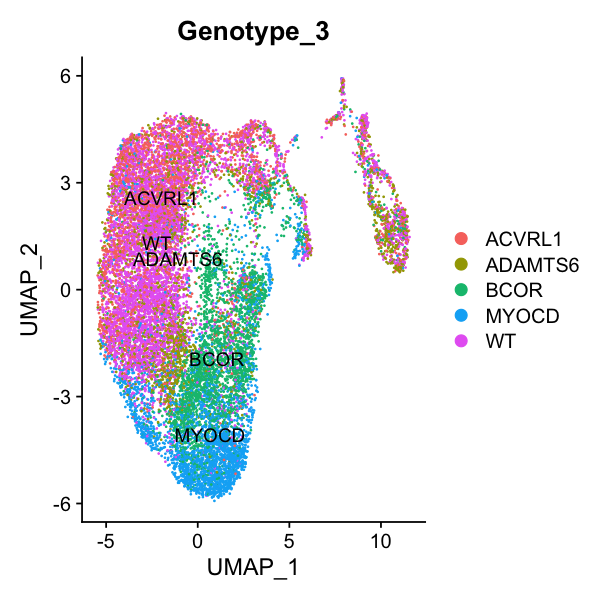

In [8]:
options(repr.plot.height=5,repr.plot.width=5)
p2 = DimPlot(pbmc,reduction = "umap", label = TRUE,group.by="Genotype_3")
p2

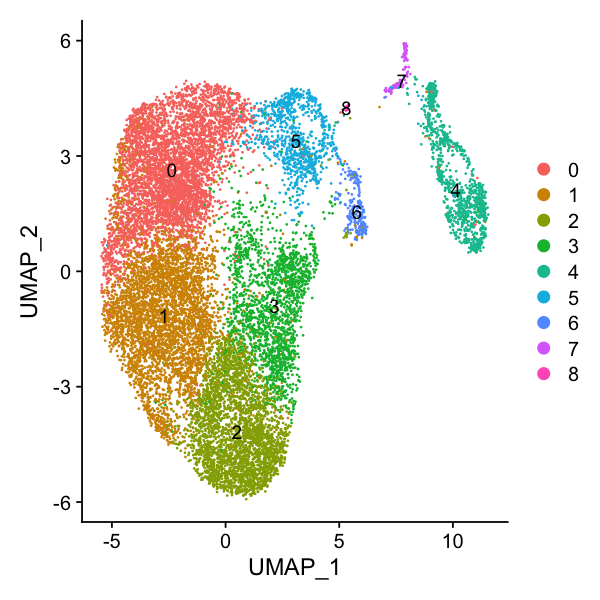

In [9]:
options(repr.plot.height=5,repr.plot.width=5)
p3 = DimPlot(pbmc,reduction = "umap", label = TRUE)
p3

In [10]:
Idents(pbmc)<-'Genotype_3'

In [11]:
all.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
all.markers %>%
  group_by(cluster) %>%
  slice_max(n = 5, order_by = avg_log2FC)

Calculating cluster ACVRL1

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster MYOCD

Calculating cluster BCOR

Calculating cluster WT

Calculating cluster ADAMTS6



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.584091e-79,1.2263855,0.342,0.193,7.140360e-75,ACVRL1,LMO3
7.948074e-86,1.2067878,0.372,0.210,2.196212e-81,ACVRL1,LRP1B
1.203852e-114,1.1450865,0.451,0.255,3.326484e-110,ACVRL1,CTB-174D11.1
8.102043e-64,1.0739716,0.329,0.197,2.238757e-59,ACVRL1,RP13-726E6.1
2.349586e-112,1.0541793,0.519,0.327,6.492377e-108,ACVRL1,RP13-726E6.2
9.950586e-221,2.0117357,0.335,0.112,2.749546e-216,MYOCD,NR2F2-AS1
1.249981e-164,1.8388753,0.274,0.093,3.453949e-160,MYOCD,RP11-759A24.3
3.019534e-268,1.7381711,0.507,0.222,8.343576e-264,MYOCD,TRABD2B
1.240274e-127,1.7068805,0.252,0.096,3.427125e-123,MYOCD,DSCAML1


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


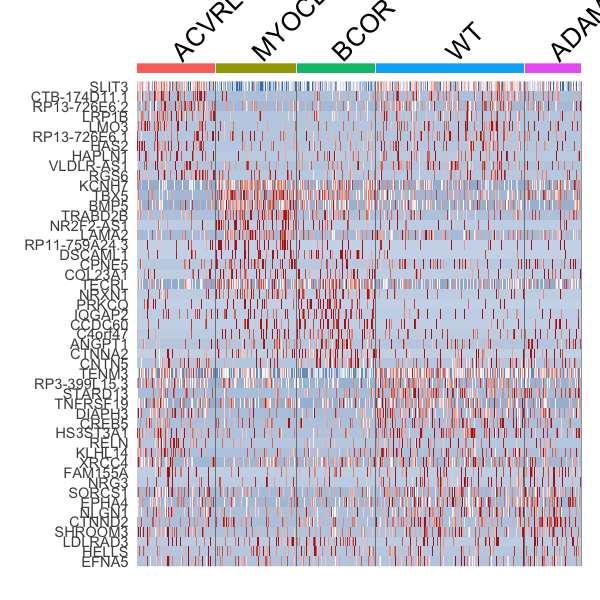

In [12]:
options(repr.plot.height=5,repr.plot.width=5)
markers<-all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
DoHeatmap(pbmc, features =markers$gene) + NoLegend() + scale_fill_gradientn(colors = c("steelblue", "white", "firebrick") )

In [13]:
sce1 <- readRDS('CM_after_reclustering.rds')
sce1

An object of class Seurat 
62959 features across 11058 samples within 2 assays 
Active assay: SCT (29161 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

In [14]:
genes<-rownames(GetAssayData(object = sce1, slot = 'data'))
features<-all.markers %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
features<-features$gene
use_features<-intersect(genes,features)

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


In [15]:
# data and labels 
labels <- pbmc$'Genotype_3'
labels <- factor(labels, levels = c('WT','ACVRL1','ADAMTS6','BCOR','MYOCD'))
use_data <- GetAssayData(object = pbmc, slot = 'data')[use_features,]

In [16]:
# generate training and testing datasets
idx <- createDataPartition(labels, p = 0.8, list = FALSE)
use_data_train <- use_data[,as.vector(idx)]
use_label_train <- labels[as.vector(idx)]
use_data_test <- use_data[,as.vector(-idx)]
use_label_test <- labels[as.vector(-idx)]

In [17]:
# training
for (title in unique(use_label_train)){
  use_train_stage <- as.matrix(use_data_train[,use_label_train==title])
  # train the model by one-class logistic regression classifier
  mm <- gelnet( t(use_train_stage), NULL, 0, 1 )
  df_oclr <- data.frame(w = mm$w)
  rownames(df_oclr) <- use_features
  write.table(df_oclr,paste0('./',title,'_marker_train.rds'),row.names = T, col.names =F)
  
}

Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.2380578 
Iteration 3 : f = 0.1739529 
Iteration 4 : f = 0.1725786 
Iteration 5 : f = 0.1725751 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.2373994 
Iteration 3 : f = 0.1782567 
Iteration 4 : f = 0.1768695 
Iteration 5 : f = 0.1768661 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.245687 
Iteration 3 : f = 0.1897274 
Iteration 4 : f = 0.188694 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.2450386 
Iteration 3 : f = 0.1896081 
Iteration 4 : f = 0.1886254 
Training a one-class model
Iteration 1 : f = 0.6931472 
Iteration 2 : f = 0.239795 
Iteration 3 : f = 0.1662572 
Iteration 4 : f = 0.1642978 
Iteration 5 : f = 0.164291 


In [18]:
# testing
df_oclr <- as.data.frame(matrix(NA,nrow = ncol(use_data_test), ncol = 5))
titles <- c('WT','ACVRL1','ADAMTS6','BCOR','MYOCD')
colnames(df_oclr) <- titles

In [19]:
for (title in titles){
  title_file <- title
  w_df <- read.table(paste0('./',title_file,'_marker_train.rds'),row.names = 1, header = F)
  use_data <- use_data_test[use_features,]
  w <- w_df[use_features,1]
  df_oclr[[title]] <- apply( use_data, 2, function(z) {cor( z, w, method="sp", use="complete.obs" )} )
  
}

In [20]:
colname <- colnames(df_oclr)
pred_type <- apply(df_oclr,1,function(z){colname[which.max(z)]})
pred_type <- factor(pred_type, levels = c('WT','ACVRL1','ADAMTS6','BCOR','MYOCD'))

In [21]:
# testing data of confusion matrix
table(data.frame(truth = use_label_test,pred = pred_type))


         pred
truth      WT ACVRL1 ADAMTS6 BCOR MYOCD
  WT      378    399     133   38   128
  ACVRL1  115    325      78   17    31
  ADAMTS6  71     94     156   25    60
  BCOR     16     49      31  307   165
  MYOCD    25     21      25   90   427

In [22]:
# test on H2
H2.obj <- sce1
data <- GetAssayData(object = H2.obj,slot = 'data')
df_oclr <- as.data.frame(matrix(NA,nrow = dim(data)[2], ncol = 5))

titles <- c('WT','ACVRL1','ADAMTS6','BCOR','MYOCD')
colnames(df_oclr) <- titles

In [23]:
for (title in titles){
  title_file <- title
  genes <-rownames(H2.obj)
    
  w_df <- read.table(paste0('./',title_file,'_marker_train.rds'),row.names = 1, header = F)
  
  use_genes <- intersect(genes,rownames(w_df))
  use_data <- data[use_genes,]
  w <- w_df[use_genes,1]
  
  df_oclr[[title]] <- apply( use_data, 2, function(z) {cor( z, w, method="sp", use="complete.obs" )})
  
}

In [24]:
colname <- colnames(df_oclr)
pred_type <- apply(df_oclr,1,function(z){colname[which.max(z)]})
pred_type <- factor(pred_type, levels = c('WT','ACVRL1','ADAMTS6','BCOR','MYOCD'))
H2.obj <- AddMetaData(H2.obj,pred_type,'pred')


Warning message:
“package ‘scales’ was built under R version 4.2.3”


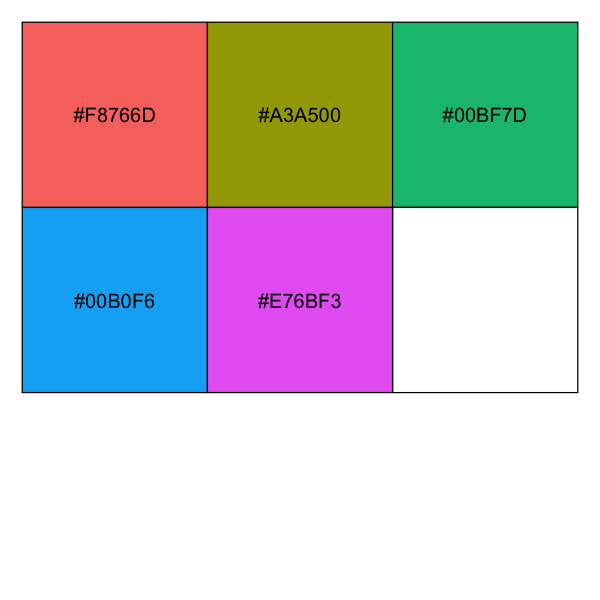

In [25]:
library(scales)
show_col(hue_pal()(5))

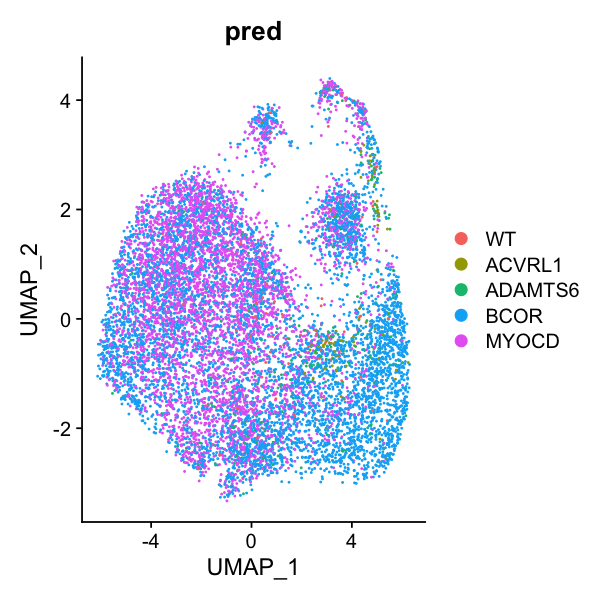

In [26]:
# UMAP showing the predicting results
options(repr.plot.height=5,repr.plot.width=5)
use_stage_colors <-hue_pal()(5)
p1 <- DimPlot(H2.obj,label = F,group.by = 'pred')+scale_color_manual(values = use_stage_colors)
print(p1)

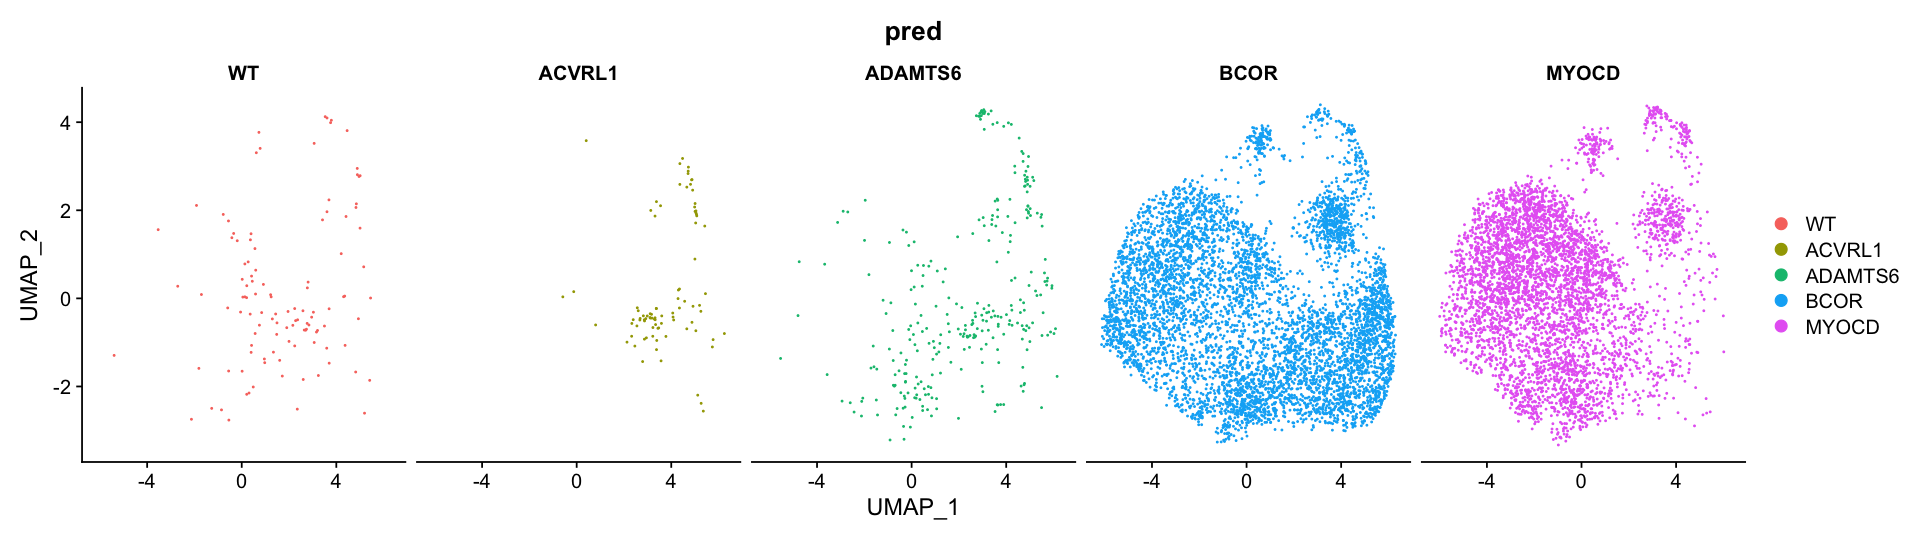

In [27]:
options(repr.plot.height=4.5,repr.plot.width=16)
p4 <- DimPlot(H2.obj,label = F,group.by = 'pred',split.by='pred')+scale_color_manual(values = use_stage_colors)
print(p4)

In [28]:
table(pred_type)

pred_type
     WT  ACVRL1 ADAMTS6    BCOR   MYOCD 
    112      89     301    5994    4562 

In [29]:
barcode<-read.csv('./barcode/1_genotyping_result/Singlet_annotation_renamed.csv')
meta<-H2.obj@meta.data
meta$X<-row.names(H2.obj@meta.data)
meta<-merge(meta,barcode,by.x='X',by.y='X',all.x=T)
rownames(meta)<-meta$X

In [30]:
H2.obj@meta.data<-meta
colnames(meta)

[1] "X"                      "orig.ident"             "nCount_RNA"            
 [4] "nFeature_RNA"           "percent.mt"             "hg38_total"            
 [7] "hg38_dup"               "hg38_libsize"           "label"                 
[10] "nCount_SCT"             "nFeature_SCT"           "SCT_snn_res.0.5"       
[13] "seurat_clusters"        "pred"                   "BCOR_X_40475263_C_T"   
[16] "WDR19_4_39182259_G_A"   "TGFBR1_9_99107879_G_A"  "CAMTA2_17_4986336_G_C" 
[19] "SP2_17_47867409_T_C"    "MYOCD_17_12121771_T_C"  "SHH_7_156383623_A_G"   
[22] "ADAMTS6_5_65051269_C_T" "ACVRL1_12_51871343_C_G" "CCDC154_16_1453708_C_A"
[25] "Genotype"

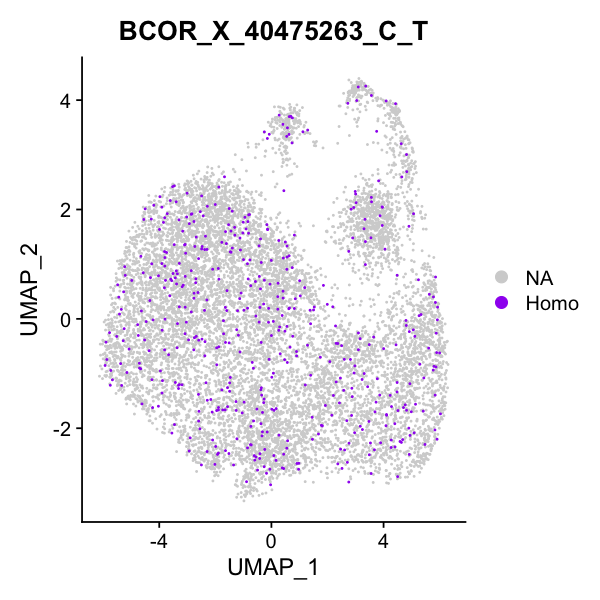

In [37]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"BCOR_X_40475263_C_T"[is.na(H2.obj@meta.data$"BCOR_X_40475263_C_T")]<-'NA'
H2.obj@meta.data$"BCOR_X_40475263_C_T"<-gsub('Heter','NA',H2.obj@meta.data$"BCOR_X_40475263_C_T")
H2.obj@meta.data$"BCOR_X_40475263_C_T"<-gsub('WT','NA',H2.obj@meta.data$"BCOR_X_40475263_C_T")
DimPlot(H2.obj, reduction = "umap",group.by="BCOR_X_40475263_C_T",order='Homo',cols=c('lightgrey','purple'))

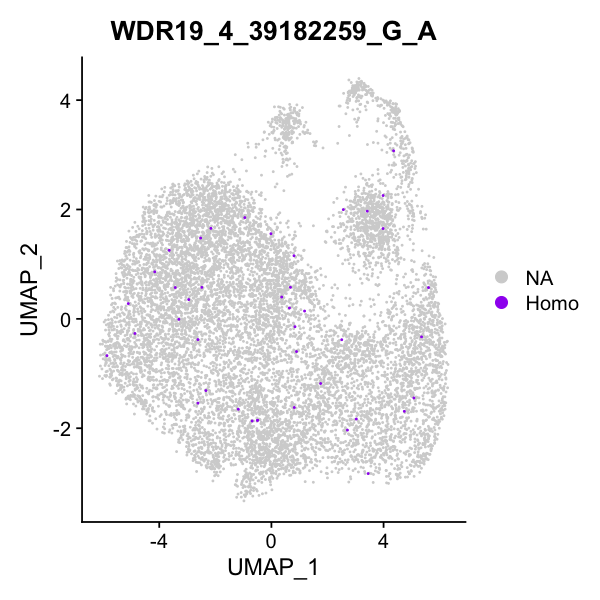

In [38]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"WDR19_4_39182259_G_A"[is.na(H2.obj@meta.data$"WDR19_4_39182259_G_A")]<-'NA'
H2.obj@meta.data$"WDR19_4_39182259_G_A"<-gsub('Heter','NA',H2.obj@meta.data$"WDR19_4_39182259_G_A")
H2.obj@meta.data$"WDR19_4_39182259_G_A"<-gsub('WT','NA',H2.obj@meta.data$"WDR19_4_39182259_G_A")
DimPlot(H2.obj, reduction = "umap",group.by="WDR19_4_39182259_G_A",order='Homo',cols=c('lightgrey','purple'))

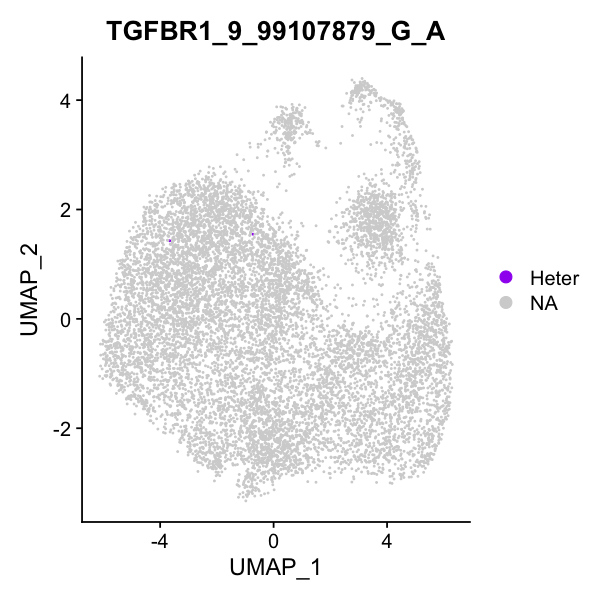

In [40]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"TGFBR1_9_99107879_G_A"[is.na(H2.obj@meta.data$"TGFBR1_9_99107879_G_A")]<-'NA'
H2.obj@meta.data$"TGFBR1_9_99107879_G_A"<-gsub('Heter','NA',H2.obj@meta.data$"TGFBR1_9_99107879_G_A")
H2.obj@meta.data$"TGFBR1_9_99107879_G_A"<-gsub('WT','NA',H2.obj@meta.data$"TGFBR1_9_99107879_G_A")
DimPlot(H2.obj, reduction = "umap",group.by="TGFBR1_9_99107879_G_A",order='Homo',cols=c('purple','lightgrey'))

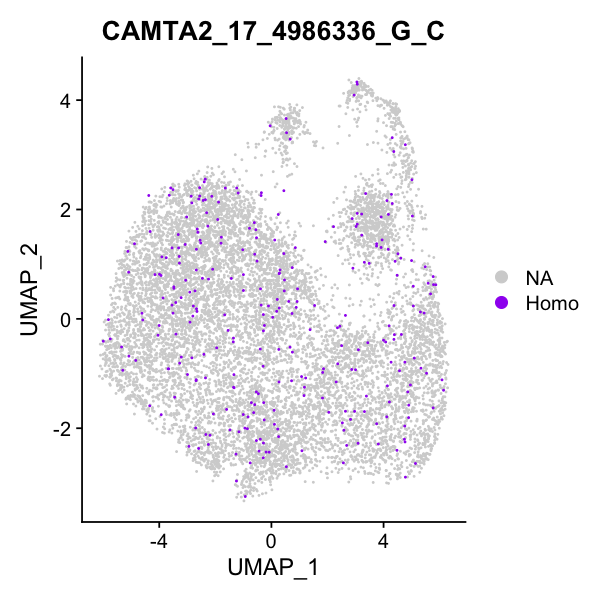

In [41]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"CAMTA2_17_4986336_G_C"[is.na(H2.obj@meta.data$"CAMTA2_17_4986336_G_C")]<-'NA'
H2.obj@meta.data$"CAMTA2_17_4986336_G_C"<-gsub('Heter','NA',H2.obj@meta.data$"CAMTA2_17_4986336_G_C")
H2.obj@meta.data$"CAMTA2_17_4986336_G_C"<-gsub('WT','NA',H2.obj@meta.data$"CAMTA2_17_4986336_G_C")
DimPlot(H2.obj, reduction = "umap",group.by="CAMTA2_17_4986336_G_C",order='Homo',cols=c('lightgrey','purple'))

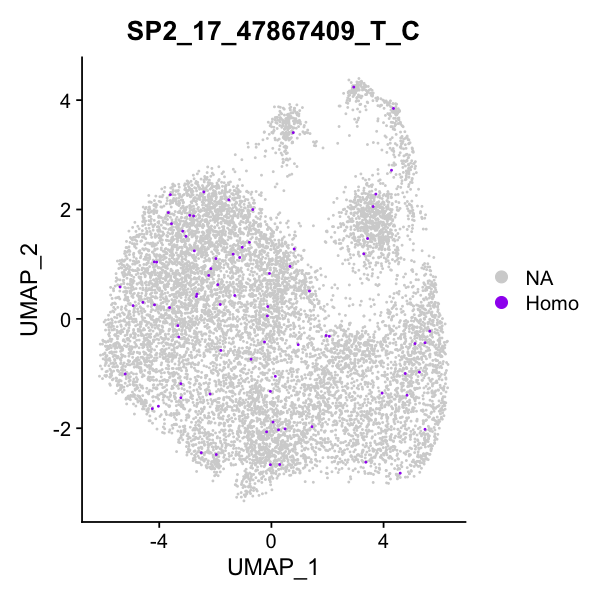

In [42]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"SP2_17_47867409_T_C"[is.na(H2.obj@meta.data$"SP2_17_47867409_T_C")]<-'NA'
H2.obj@meta.data$"SP2_17_47867409_T_C"<-gsub('Heter','NA',H2.obj@meta.data$"SP2_17_47867409_T_C")
H2.obj@meta.data$"SP2_17_47867409_T_C"<-gsub('WT','NA',H2.obj@meta.data$"SP2_17_47867409_T_C")
DimPlot(H2.obj, reduction = "umap",group.by="SP2_17_47867409_T_C",order='Homo',cols=c('lightgrey','purple'))

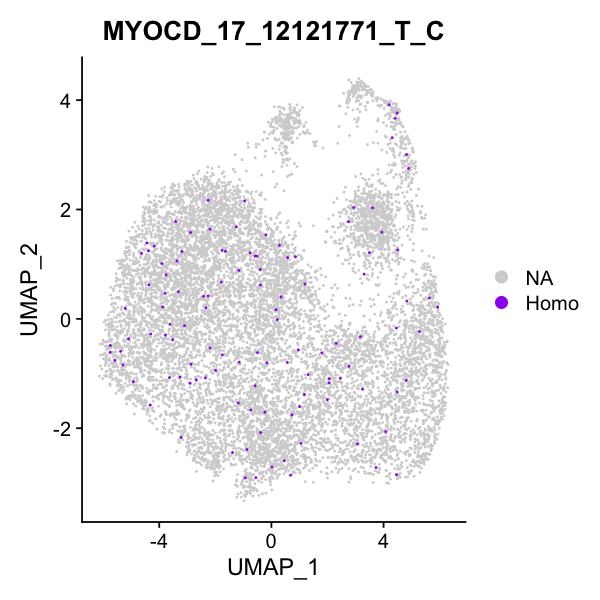

In [43]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"MYOCD_17_12121771_T_C"[is.na(H2.obj@meta.data$"MYOCD_17_12121771_T_C")]<-'NA'
H2.obj@meta.data$"MYOCD_17_12121771_T_C"<-gsub('Heter','NA',H2.obj@meta.data$"MYOCD_17_12121771_T_C")
H2.obj@meta.data$"MYOCD_17_12121771_T_C"<-gsub('WT','NA',H2.obj@meta.data$"MYOCD_17_12121771_T_C")
DimPlot(H2.obj, reduction = "umap",group.by="MYOCD_17_12121771_T_C",order='Homo',cols=c('lightgrey','purple'))

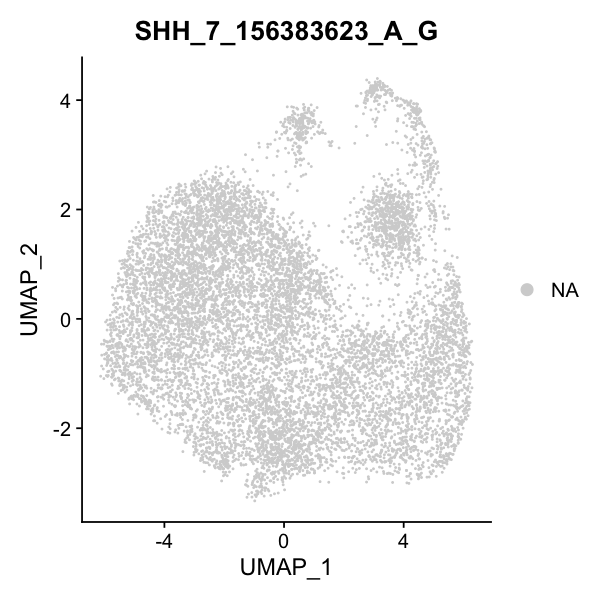

In [44]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"SHH_7_156383623_A_G"[is.na(H2.obj@meta.data$"SHH_7_156383623_A_G")]<-'NA'
H2.obj@meta.data$"SHH_7_156383623_A_G"<-gsub('Heter','NA',H2.obj@meta.data$"SHH_7_156383623_A_G")
H2.obj@meta.data$"SHH_7_156383623_A_G"<-gsub('WT','NA',H2.obj@meta.data$"SHH_7_156383623_A_G")
DimPlot(H2.obj, reduction = "umap",group.by="SHH_7_156383623_A_G",order='Homo',cols=c('lightgrey','purple'))

In [47]:
table(barcode$"SHH_7_156383623_A_G")


Heter    WT 
    1  1103 

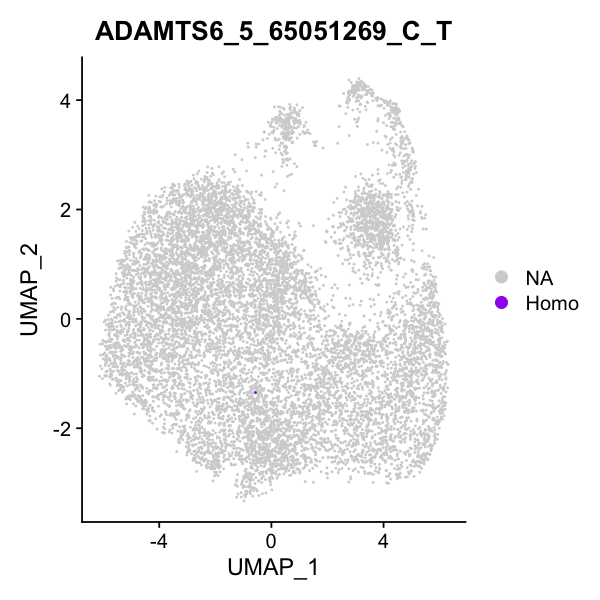

In [48]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"ADAMTS6_5_65051269_C_T"[is.na(H2.obj@meta.data$"ADAMTS6_5_65051269_C_T")]<-'NA'
H2.obj@meta.data$"ADAMTS6_5_65051269_C_T"<-gsub('Heter','NA',H2.obj@meta.data$"ADAMTS6_5_65051269_C_T")
H2.obj@meta.data$"ADAMTS6_5_65051269_C_T"<-gsub('WT','NA',H2.obj@meta.data$"ADAMTS6_5_65051269_C_T")
DimPlot(H2.obj, reduction = "umap",group.by="ADAMTS6_5_65051269_C_T",order='Homo',cols=c('lightgrey','purple'))

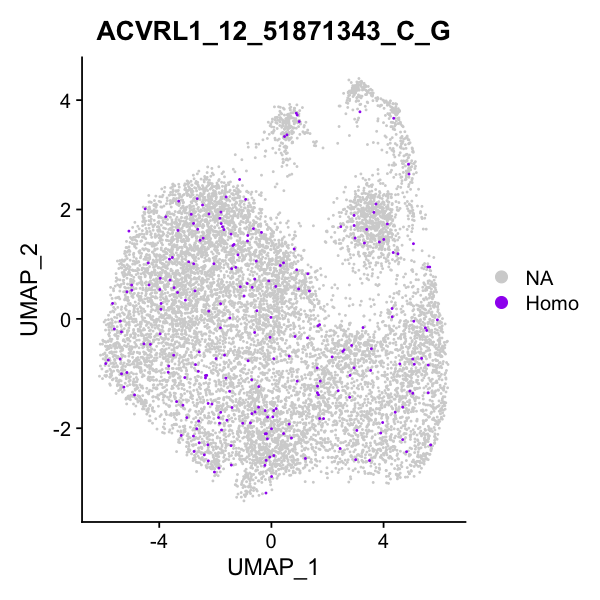

In [49]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"ACVRL1_12_51871343_C_G"[is.na(H2.obj@meta.data$"ACVRL1_12_51871343_C_G")]<-'NA'
H2.obj@meta.data$"ACVRL1_12_51871343_C_G"<-gsub('Heter','NA',H2.obj@meta.data$"ACVRL1_12_51871343_C_G")
H2.obj@meta.data$"ACVRL1_12_51871343_C_G"<-gsub('WT','NA',H2.obj@meta.data$"ACVRL1_12_51871343_C_G")
DimPlot(H2.obj, reduction = "umap",group.by="ACVRL1_12_51871343_C_G",order='Homo',cols=c('lightgrey','purple'))

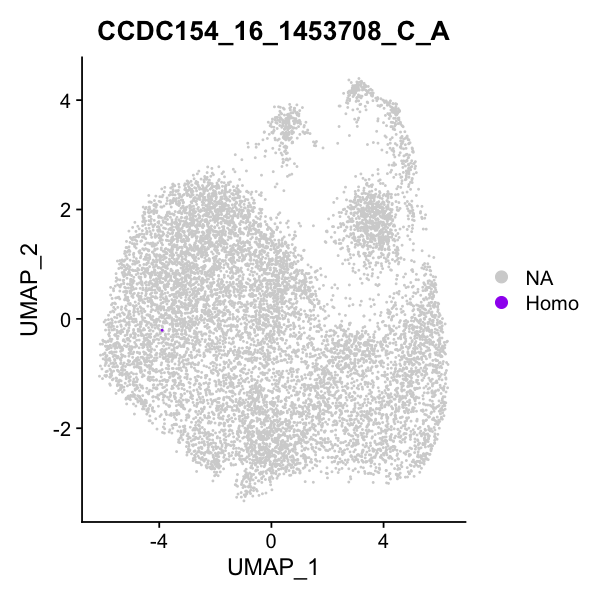

In [50]:
options(repr.plot.height=5,repr.plot.width=5)
H2.obj@meta.data$"CCDC154_16_1453708_C_A"[is.na(H2.obj@meta.data$"CCDC154_16_1453708_C_A")]<-'NA'
H2.obj@meta.data$"CCDC154_16_1453708_C_A"<-gsub('Heter','NA',H2.obj@meta.data$"CCDC154_16_1453708_C_A")
H2.obj@meta.data$"CCDC154_16_1453708_C_A"<-gsub('WT','NA',H2.obj@meta.data$"CCDC154_16_1453708_C_A")
DimPlot(H2.obj, reduction = "umap",group.by="CCDC154_16_1453708_C_A",order='Homo',cols=c('lightgrey','purple'))

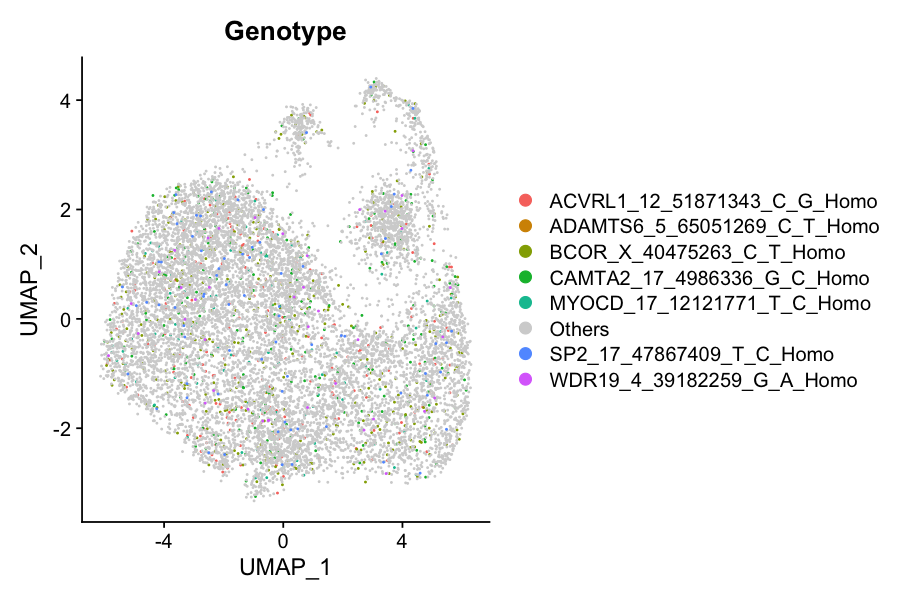

In [62]:
options(repr.plot.height=5,repr.plot.width=7.5)
p2 = DimPlot(H2.obj,reduction = "umap", label = FALSE,group.by="Genotype",order=T,cols=c('#F8766D','#D39200','#93AA00','#00BA38','#00C19F','lightgrey','#619CFF','#DB72FB','#FF61C3'))
p2